In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Se placer dans le bon répertoire
import os
import sys

ROOT_DIR = os.path.abspath("../../")

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)  # Les caractéristiques commencent à la colonne 1
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)     # La première colonne est la cible
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

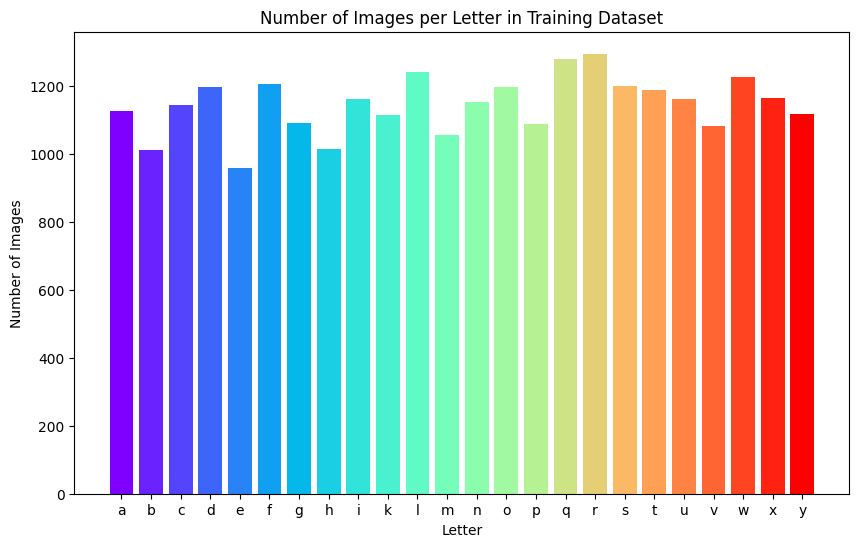

In [6]:
train_dataset_path = os.path.join(ROOT_DIR, "data/sign_mnist_train.csv")
test_dataset_path = os.path.join(ROOT_DIR, "data/sign_mnist_test.csv")

train_dataset = CustomDataset(train_dataset_path)
test_dataset = CustomDataset(test_dataset_path)

# Visualisation du nombre d'image par classe dans le jeu d'entraînement
letter_counts = {}
for _, label in train_dataset:
    letter = chr(label.item() + 97)  # Convertir le label en lettre (97 est le code ASCII pour 'a')
    if letter in letter_counts:
        letter_counts[letter] += 1
    else:
        letter_counts[letter] = 1

sorted_letters = sorted(letter_counts.keys())

# Créer l'histogramme
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(sorted_letters)))
plt.bar(sorted_letters, [letter_counts[letter] for letter in sorted_letters], color=colors)
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in Training Dataset')
plt.show()


In [32]:
# Définir les hyperparamètres
input_size = 784
hidden_size = 500
num_classes = 26

# Nous allons faire varier les epochs et le learning rate afin de trouver les meilleurs hyperparamètres
epochs = [30, 40, 50, 60, 70, 80, 90, 100]
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# Initialiser les listes pour stocker les résultats
train_accuracies = []

for epoch in epochs:
    for lr in learning_rates:
        model = SimpleModel(input_size, hidden_size, num_classes)
        
        # Définir la fonction de coût et l'optimiseur
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Entraîner le modèle
        for e in range(epoch):
            for i, (images, labels) in enumerate(DataLoader(train_dataset, batch_size=100, shuffle=True)):
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if (i+1) % 100 == 0:
                    print(f'Epoch [{e+1}/{epoch}], Step [{i+1}/{len(train_dataset)//100}], Loss: {loss.item():.4f}')
        
        # Tester le modèle
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in DataLoader(test_dataset, batch_size=100):
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            train_accuracies.append((epoch, lr, correct / total))
            print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Epoch [1/30], Step [100/274], Loss: 5.4906
Epoch [1/30], Step [200/274], Loss: 2.6222
Epoch [2/30], Step [100/274], Loss: 1.7401
Epoch [2/30], Step [200/274], Loss: 1.3843
Epoch [3/30], Step [100/274], Loss: 1.2160
Epoch [3/30], Step [200/274], Loss: 1.1707
Epoch [4/30], Step [100/274], Loss: 0.3458
Epoch [4/30], Step [200/274], Loss: 0.9202
Epoch [5/30], Step [100/274], Loss: 0.1308
Epoch [5/30], Step [200/274], Loss: 0.4029
Epoch [6/30], Step [100/274], Loss: 0.1970
Epoch [6/30], Step [200/274], Loss: 0.1697
Epoch [7/30], Step [100/274], Loss: 0.1961
Epoch [7/30], Step [200/274], Loss: 0.1111
Epoch [8/30], Step [100/274], Loss: 0.1528
Epoch [8/30], Step [200/274], Loss: 0.0983
Epoch [9/30], Step [100/274], Loss: 0.0434
Epoch [9/30], Step [200/274], Loss: 0.0358
Epoch [10/30], Step [100/274], Loss: 0.0126
Epoch [10/30], Step [200/274], Loss: 0.0274
Epoch [11/30], Step [100/274], Loss: 0.6533
Epoch [11/30], Step [200/274], Loss: 0.0463
Epoch [12/30], Step [100/274], Loss: 0.3371
Epoch 

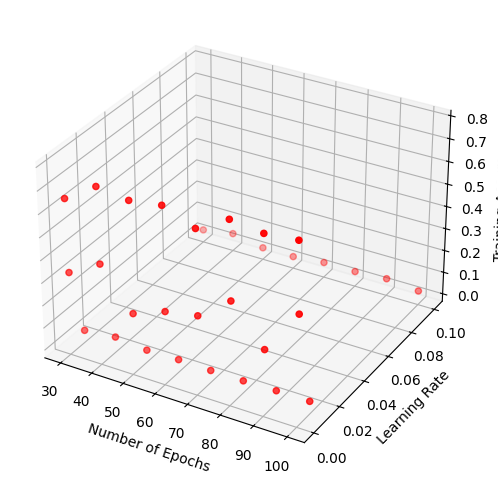

In [34]:
train_accuracies = np.array(train_accuracies)
# Créer un graphique en 3D pour visualiser les résultats
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_accuracies[:, 0], train_accuracies[:, 1], train_accuracies[:, 2], c='r', marker='o')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Training Accuracy')
plt.show()

In [10]:
# On observe que le meilleur couple (nombre d'epochs, learning rate) est (100, 0.0001)
# On va donc entraîner le modèle avec ces hyperparamètres
input_size = 784
num_classes = 26
epoch = 100
lr = 0.001

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Entraîner le modèle
for e in range(epoch):
    for i, (images, labels) in enumerate(DataLoader(train_dataset, batch_size=100, shuffle=True)):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


# Tester le modèle
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in DataLoader(test_dataset, batch_size=100):
        outputs = model(images)
        _, predicted = loss_fn(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')


IndexError: Target 18 is out of bounds.

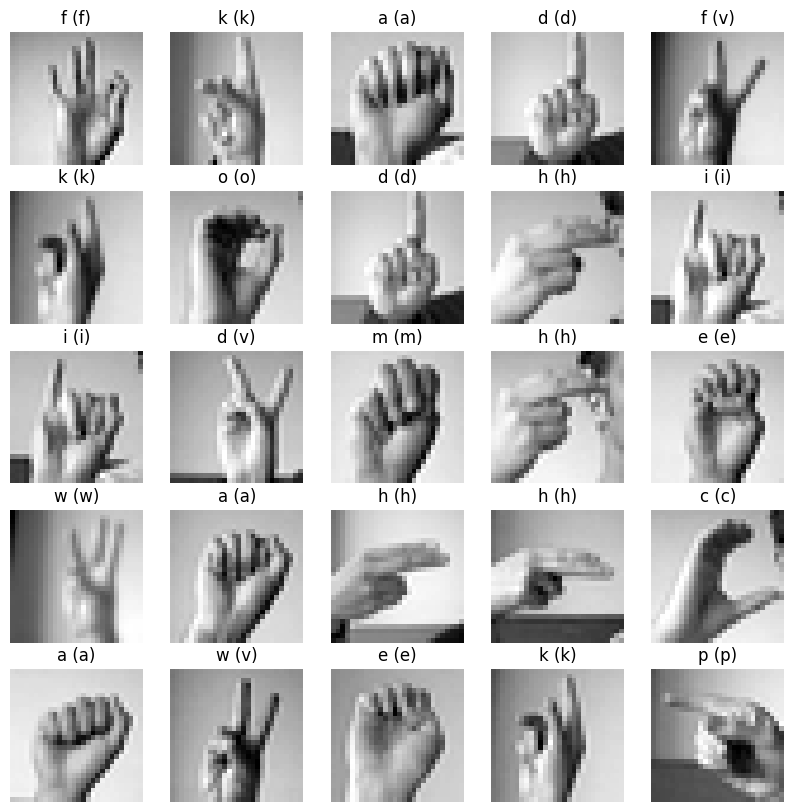

In [42]:
# Visualiser les prédictions
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = test_dataset[i][0].reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    with torch.no_grad():
        output = model(test_dataset[i][0].reshape(1, 784))
        _, predicted = torch.max(output.data, 1)
        plt.title(f'{chr(predicted.item() + 97)} ({chr(test_dataset[i][1].item() + 97)})')

    plt.axis('off')
plt.show()


In [ ]:
# Enregistrer le modèle
torch.save(model.state_dict(), os.path.join(ROOT_DIR, "models/sign_language_model1.pth"))